In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from utils import plot_auc_roc_curve

%matplotlib inline

In [2]:
df = pd.read_csv(r'heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape

(918, 12)

In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [8]:
df['Sex'].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64

In [9]:
df['RestingECG'].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [10]:
df['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [11]:
df['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

In [12]:
# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [13]:
# Identify numerical and categorical columns
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
label_encoded_features = ['Sex', 'ExerciseAngina']
one_hot_encoded_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [14]:
# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('label', OrdinalEncoder(), label_encoded_features),  # Use OrdinalEncoder for binary categorical features
        ('onehot', OneHotEncoder(drop='first'), one_hot_encoded_features)  # One-hot encode other categorical features
    ])

# Apply the transformations
X_transformed = preprocessor.fit_transform(X)

# Convert to DataFrame to see the final result
# Retrieve feature names after transformation for readability
onehot_encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_encoded_features)
column_names = numerical_features + label_encoded_features + list(onehot_encoded_columns)
X_transformed = pd.DataFrame(X_transformed, columns=column_names)

# Display the preprocessed data
X_transformed.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [15]:
X_transformed.shape

(918, 14)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, 
                                                    test_size=0.20, 
                                                    random_state=47)

In [83]:
# let's define the model

model = XGBClassifier(
    booster='gbtree',               # Type of booster to use (options: 'gbtree', 'gblinear', 'dart')
    objective='binary:logistic',    # Objective function for binary classification
    n_estimators=100,               # Number of boosting rounds (trees)
    max_depth=4,                    # Maximum depth of a tree
    gamma=1.0,                        # spliting condition
    learning_rate=0.3,              # Step size shrinkage (also known as "eta")
    verbosity=1,                    # Verbosity of printing messages (0 for silent, 1 for warning, 2 for info)
    silent=None,                    # Deprecated, use verbosity instead
    subsample=1,                    # Fraction of samples used for training each tree
    colsample_bytree=1,             # Fraction of features to use for each tree
    colsample_bylevel=1,            # Fraction of features for each level of the tree
    colsample_bynode=1,             # Fraction of features for each node split
    reg_alpha=1.0,                    # L1 regularization term on weights (default is no regularization)
    reg_lambda=2.0,                   # L2 regularization term on weights
    scale_pos_weight=1,             # Controls the balance of positive and negative weights
    base_score=0.5,                 # Initial prediction score (global bias)
    random_state=0,                 # Seed for reproducibility
    eval_metric=None,               # Evaluation metric for validation data; None defaults to logloss for binary classification
    seed=None                       # Alias for random_state, can also set a random seed here
)

model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [84]:
y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
y_train_proba, y_test_proba = model.predict_proba(X_train)[:, 1], model.predict_proba(X_test)[:, 1]

In [85]:
# train set
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       328
           1       0.92      0.94      0.93       406

    accuracy                           0.92       734
   macro avg       0.92      0.92      0.92       734
weighted avg       0.92      0.92      0.92       734



In [86]:
# test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        82
           1       0.83      0.93      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



AUC Score: 0.9721179262285233


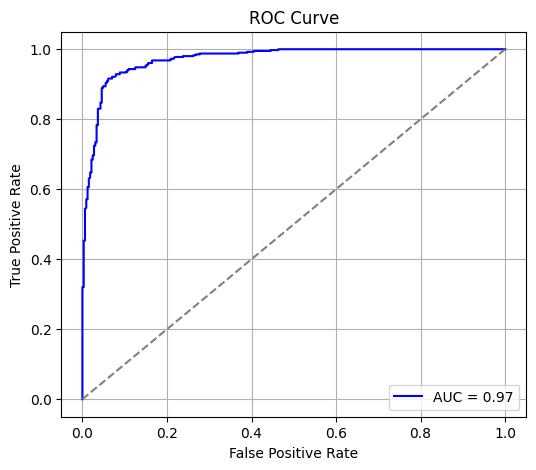

In [87]:
# plot auc-roc
# train set
plot_auc_roc_curve(
    y_train,
    y_train_proba
)

AUC Score: 0.9167862266857963


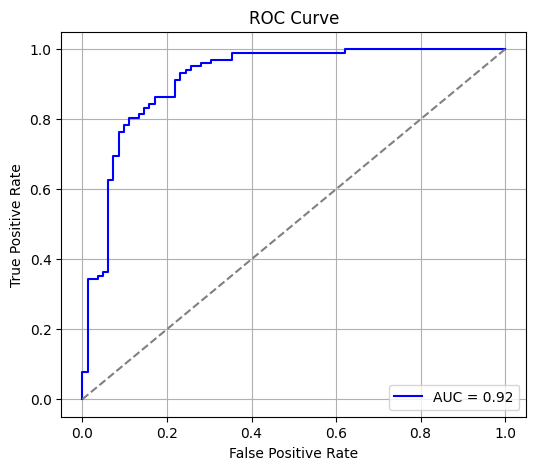

In [88]:
# test set
plot_auc_roc_curve(
    y_test,
    y_test_proba
)

In [89]:
# Get feature importance scores
feature_weights = model.get_booster().get_score(importance_type='weight')  # 'weight' can be 'gain' or 'cover' as well
feature_weights

{'Age': 17.0,
 'RestingBP': 20.0,
 'Cholesterol': 27.0,
 'MaxHR': 17.0,
 'Oldpeak': 21.0,
 'Sex': 13.0,
 'ExerciseAngina': 8.0,
 'ChestPainType_ATA': 10.0,
 'ChestPainType_NAP': 7.0,
 'ChestPainType_TA': 3.0,
 'RestingECG_ST': 2.0,
 'ST_Slope_Flat': 5.0,
 'ST_Slope_Up': 7.0}

##### **Hyperparameters Tuning**

In [90]:
from sklearn.model_selection import RandomizedSearchCV

In [109]:
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5]
}

# Initialize the model
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=1000,                     # Number of parameter settings sampled
    scoring='f1_weighted',              # Scoring metric to evaluate
    cv=3,                            # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1                        # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.5, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 2, 5],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [110]:
# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best f1_weighted:", random_search.best_score_)

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 5, 'colsample_bytree': 0.8}
Best f1_weighted: 0.8852898152792217


In [111]:
# Use the best parameters to fit the model
best_xgb = random_search.best_estimator_

In [112]:
y_train_pred, y_test_pred = best_xgb.predict(X_train), best_xgb.predict(X_test)
y_train_proba, y_test_proba = best_xgb.predict_proba(X_train)[:, 1], best_xgb.predict_proba(X_test)[:, 1]

In [113]:
# train set
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       328
           1       0.90      0.94      0.92       406

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



In [114]:
# test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        82
           1       0.85      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



AUC Score: 0.9625660819416076


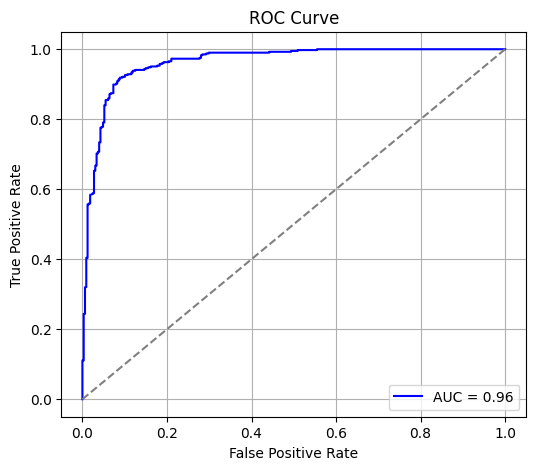

In [115]:
plot_auc_roc_curve(
    y_train,
    y_train_proba
)

AUC Score: 0.8992109038737446


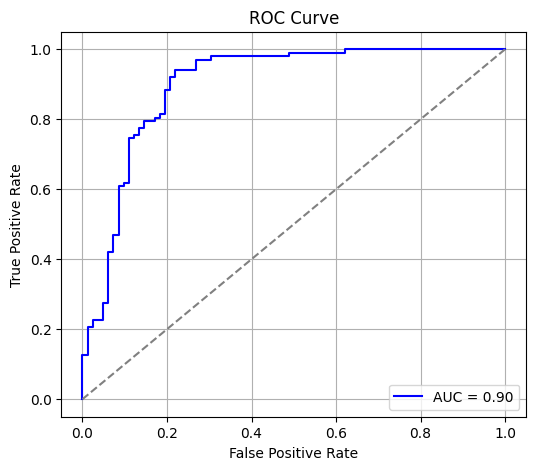

In [116]:
plot_auc_roc_curve(
    y_test,
    y_test_proba
)

In [117]:
# Get feature importance scores
feature_weights = best_xgb.get_booster().get_score(importance_type='weight')  # 'weight' can be 'gain' or 'cover' as well
feature_weights

{'Age': 8.0,
 'RestingBP': 8.0,
 'Cholesterol': 13.0,
 'MaxHR': 10.0,
 'Oldpeak': 12.0,
 'Sex': 6.0,
 'ExerciseAngina': 4.0,
 'ChestPainType_ATA': 5.0,
 'ChestPainType_NAP': 4.0,
 'ChestPainType_TA': 2.0,
 'ST_Slope_Flat': 3.0,
 'ST_Slope_Up': 4.0}

In [30]:
# help(xgboost.XGBClassifier)